In [1438]:
def retrieve_data(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    # Extract position data and start
    start = None
    positions = []
    for line in data:
        if "start" in line:
            split_line = line.split("->")[1].split("|")
            translation_data = [float(x) for x in split_line[0].split(":")[1].strip().strip("(").strip(")").split(",")]
            rotation_data = [float(x) for x in split_line[1].split(":")[1].strip().strip("(").strip(")").split(",")]
            start = {
                "translation": translation_data,
                "rotation": rotation_data,
            }
            continue
        split_line = line.split(",")
        x = float(split_line[0].split(":")[1])
        y = float(split_line[1].split(":")[1])
        positions.append((x, y))

    return start, positions

In [1439]:
# start, positions = retrieve_data("data/robot_position_(0.96, 0.492, 0.05)_0.txt")
start, positions = retrieve_data("data/robot_position_(7.6, 3.5, 0.05)_0.txt")
# start, positions = retrieve_data("data/robot_position_(5.2, 6.0, 0.05)_0.txt")


In [1440]:
print(start)
print(positions)

{'translation': [7.6, 3.5, 0.05], 'rotation': [0.0, 0.0, 1.0, 0.0]}
[(0.0, 0.0), (0.15382338770142104, -0.3457934568581723), (-0.1086848695988395, -0.5107081143219653), (-0.2831447865304082, -0.9306185808133166), (-0.2580547136852438, -1.0437866417450363), (0.017788242830858503, -1.170239539538959), (0.2603086408963402, -0.776432427477017), (0.3835369271939493, -0.5751052377627132), (0.41530180087313884, -0.1589445577009583), (0.29931137086327153, 0.5431433894411964), (0.9444650470866534, 0.8084414695513296), (1.7275933717566867, 0.48439041172792124), (1.811364556777606, 0.1217216997021696), (1.5458645303832688, -0.5190877268540725), (1.310358804189337, -1.0745160168095391), (0.9824304430344146, -1.996742458923537), (0.6558151549251577, -2.91525672554784), (0.5475599045842804, -3.2806122232619597), (1.003227111011753, -3.565245603873586), (1.206621872711122, -3.69988682532721), (1.4890850513517229, -3.762236869845392), (1.7062905319124906, -3.4612360789329646), (2.12341527616541, -2.68

In [1441]:
import numpy as np

def orient_positions(start, positions):
    # If start data exists, offset all the points by the translation
    # Then rotate the points by the rotation
    if start:
        # Use Webot starting translation and rotation data
        translation = start['translation']
        if start['rotation'][3] != 0:
            rotation_angle = start['rotation'][3] + 1.57/2
        else:
            rotation_angle =  start['rotation'][3]

        # Offset translation
        positions = [
            (
                (x + translation[0]),
                (y + translation[1])
            )
            for x, y in positions
        ]

        # Apply 2D rotation matrix for the angle
        cos_angle = np.cos(rotation_angle)
        sin_angle = np.sin(rotation_angle)
        
        positions = [
            (
                x * cos_angle - y * sin_angle,
                x * sin_angle + y * cos_angle
            )
            for x, y in positions
        ]
        return positions
    return positions

In [1442]:
augmented_positions = orient_positions(start, positions)

In [1443]:
augmented_positions[:5]

[(np.float64(7.6), np.float64(3.5)),
 (np.float64(7.753823387701421), np.float64(3.154206543141828)),
 (np.float64(7.49131513040116), np.float64(2.9892918856780346)),
 (np.float64(7.316855213469592), np.float64(2.5693814191866835)),
 (np.float64(7.341945286314756), np.float64(2.4562133582549635))]

In [1444]:
import matplotlib.pyplot as plt
import numpy as np

def map_positions(data):
    data = np.array(data)
    plt.plot(data[:, 0], data[:, 1])
    # Label Point 0 as "Start"
    plt.text(data[0, 0], data[0, 1], "Start", fontsize=12, verticalalignment='bottom')
    # Label Last Point as "End"
    plt.text(data[-1, 0], data[-1, 1], "End", fontsize=12, verticalalignment='bottom')
    plt.show()

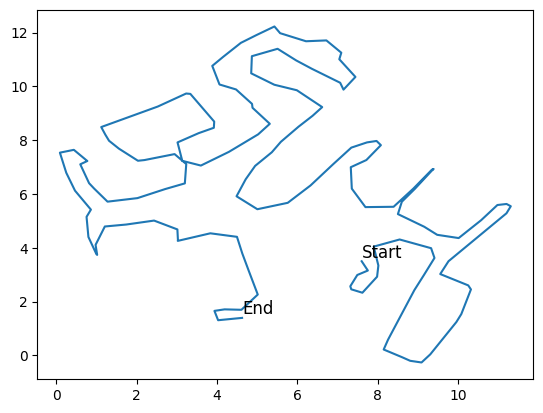

In [1445]:
map_positions(augmented_positions)

In [1446]:
min_x = min([x for x, y in augmented_positions])
max_x = max([x for x, y in augmented_positions])
min_y = min([y for x, y in augmented_positions])
max_y = max([y for x, y in augmented_positions])

bottom_left = (min_x, min_y)
top_right = (max_x, max_y)

print(bottom_left)
print(top_right)

(np.float64(0.09167117081772513), np.float64(-0.26223686984539185))
(np.float64(11.310298039019571), np.float64(12.223870011112334))


In [1447]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

map_image_path = "apartment.jpg"
img = plt.imread(map_image_path)

def overlayed_map_positions(data):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the background image
    # extent specifies the left, right, bottom, and top sides of the image.
    # Ensure that the extent covers the range of the data appropriately.
    # ax.imshow(img, extent=[data[:, 0].min(), data[:, 0].max(), data[:, 1].min(), data[:, 1].max()], aspect='auto')
    bottom_left = (-1, -.5)
    top_right = (11.5, 10)

    ax.imshow(img, extent=[bottom_left[0], top_right[0], bottom_left[1], top_right[1]], aspect='auto')

    # Convert your data to a NumPy array
    data = np.array(data)

    # Create a color gradient for the path
    points = np.array([data[:, 0], data[:, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Normalize colors over the length of the data
    norm = Normalize(vmin=0, vmax=len(data)-1)
    colors = plt.cm.viridis(norm(np.arange(len(data))))

    # Create a line collection with gradient
    lc = LineCollection(segments, cmap='viridis', norm=norm, linewidth=2)
    lc.set_array(np.arange(len(data)))

    # Add the line collection to the axis
    line = ax.add_collection(lc)

    # Label the start point
    ax.text(data[0, 0], data[0, 1], "Start", fontsize=12, verticalalignment='bottom', color="red")

    # Label the end point
    ax.text(data[-1, 0], data[-1, 1], "End", fontsize=12, verticalalignment='bottom', color="red")

    # Add color bar to show the gradient scale
    cbar = plt.colorbar(line, ax=ax)
    cbar.set_label("Path Progression (Older to Newer Points)")

    # Set limits based on the data
    ax.set_xlim([min(bottom_left[0], data[:, 0].min()), max(top_right[0], data[:, 0].max())])
    ax.set_ylim([min(bottom_left[1], data[:, 1].min()), max(top_right[1], data[:, 1].max())])

    # Display the plot
    plt.show()

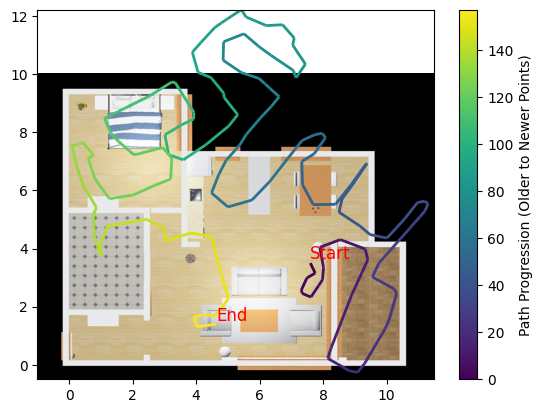

In [1448]:
overlayed_map_positions(augmented_positions)

In [1449]:
filename_map = {
    "(7.6, 3.5, 0.05)": "Zone 1",
    "(5.2, 6.0, 0.05)": "Zone 2",
    "(1.8, 6.3, 0.05)": "Zone 3",
    "(0.96, 0.492, 0.05)": "Zone 4",
}

In [1450]:
# Grab all the data files
import os

data_files = os.listdir("data")

# Sort the data files by the number in the file name
